In [1]:
%cd /scratch_net/biwidl214/ecetin_scratch/GSCodec

/scratch_net/biwidl214/ecetin_scratch/GSCodec


/scratch_net/biwidl214/ecetin/conda_envs/gscodec/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import math
import torch
from submodules.diff_gaussian_rasterization.jit_setup import setup
from scene.cameras import Camera
from scene import Scene
from models.splatting.base_gaussian_model import BaseGaussianModel
from config.build_config_spaces import ConfigReader
setup()

from gaussian_renderer import render

Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/pointops/build.ninja...
Building extension module pointops...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module pointops...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...


ninja: no work to do.


Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/octree_generation/build.ninja...
Building extension module octree_generation...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module octree_generation...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/gaussian_aggregation/build.ninja...
Building extension module gaussian_aggregation...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gaussian_aggregation...


ninja: no work to do.


Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/diff_gaussian_rasterization/build.ninja...
Building extension module diff_gaussian_rasterization...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module diff_gaussian_rasterization...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module diff_gaussian_rasterization, skipping build step...
Loading extension module diff_gaussian_rasterization...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module diff_gaussian_rasterization, skipping build step...
Loading extension module diff_gaussian_rasterization...


In [3]:
reader = ConfigReader("config/preset_configs/base_gaussian.yaml")
dataset = reader.dataset_config
pipeline = reader.pipeline_config
optimization = reader.optimization_config

gaussians = BaseGaussianModel(dataset)
checkpoint = "./output/base/train/checkpoints/ckpt_30000.pth"
params, first_iter = torch.load(checkpoint)
gaussians.restore_model(params[:-1])

In [4]:
import random
from utils.system_utils import searchForMaxIteration
from scene.dataset_readers import sceneLoadTypeCallbacks
import os
from utils.camera_utils import camera_to_JSON, cameraList_from_camInfos
import json, logging

class Scene:

    gaussians: BaseGaussianModel

    def __init__(
        self,
        args,
        gaussians: BaseGaussianModel,
        load_iteration=None,
        shuffle=True,
        resolution_scales=[1.0],
    ):
        """b
        :param path: Path to colmap scene main folder.
        """
        self.model_path = args.model_path
        self.loaded_iter = None
        self.gaussians = gaussians

        logging.info("SCENE SETUP")

        if load_iteration:
            if load_iteration == -1:
                self.loaded_iter = searchForMaxIteration(
                    os.path.join(self.model_path, "point_cloud")
                )
            else:
                self.loaded_iter = load_iteration
            logging.info("Loading trained model at iteration {}".format(self.loaded_iter))

        self.train_cameras = {}
        self.test_cameras = {}

        if os.path.exists(os.path.join(args.data_path, "sparse")):
            scene_info = sceneLoadTypeCallbacks["Colmap"](args.data_path, args.images, args.eval)
        elif os.path.exists(os.path.join(args.data_path, "transforms_train.json")):
            logging.info("Found transforms_train.json file, assuming Blender data set!")
            scene_info = sceneLoadTypeCallbacks["Blender"](
                args.data_path, args.white_background, args.eval
            )
        else:
            assert False, "Could not recognize scene type!"

        if not self.loaded_iter:
            with open(scene_info.ply_path, "rb") as src_file, open(
                os.path.join(self.model_path, "input.ply"), "wb"
            ) as dest_file:
                dest_file.write(src_file.read())
            json_cams = []
            camlist = []
            if scene_info.test_cameras:
                camlist.extend(scene_info.test_cameras)
            if scene_info.train_cameras:
                camlist.extend(scene_info.train_cameras)
            for id, cam in enumerate(camlist):
                json_cams.append(camera_to_JSON(id, cam))
            with open(os.path.join(self.model_path, "cameras.json"), "w") as file:
                json.dump(json_cams, file)

        if shuffle:
            random.shuffle(scene_info.train_cameras)  # Multi-res consistent random shuffling
            random.shuffle(scene_info.test_cameras)  # Multi-res consistent random shuffling

        self.cameras_extent = scene_info.nerf_normalization["radius"]

        for resolution_scale in resolution_scales:
            logging.info("Loading Training Cameras")
            self.train_cameras[resolution_scale] = cameraList_from_camInfos(
                scene_info.train_cameras, resolution_scale, args
            )
            logging.info("Loading Test Cameras")
            self.test_cameras[resolution_scale] = cameraList_from_camInfos(
                scene_info.test_cameras, resolution_scale, args
            )


In [5]:
dataset.data_path = dataset.data_path + "/tandt/train"
scene = Scene(dataset, gaussians)
camera = scene.train_cameras[1.0][0]

Reading camera 301/301


In [374]:
import numpy as np
import torch.nn as nn
from utils.graphics_utils import getProjectionMatrix, getWorld2View2

def get_full_rotation_matrix(deg_x, deg_y, deg_z):
    # Convert degrees to radians
    theta = np.radians(deg_x)  # Rotation around X-axis
    phi = np.radians(deg_y)    # Rotation around Y-axis
    psi = np.radians(deg_z)    # Rotation around Z-axis

    # Rotation matrices for each axis
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])

    Ry = np.array([
        [np.cos(phi), 0, np.sin(phi)],
        [0, 1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
    ])

    Rz = np.array([
        [np.cos(psi), -np.sin(psi), 0],
        [np.sin(psi), np.cos(psi), 0],
        [0, 0, 1]
    ])

    # Compute the full rotation matrix: First roll, then pitch, then yaw
    R = Rz @ Ry @ Rx
    return R


class Camera(nn.Module):
    def __init__(
        self,
        colmap_id,
        R,
        T,
        FoVx,
        FoVy,
        image,
        gt_alpha_mask,
        image_name,
        uid,
        trans=np.array([0.0, 0.0, 0.0]),
        scale=1.0,
        data_device="cuda",
    ):
        super(Camera, self).__init__()

        self.uid = uid
        self.colmap_id = colmap_id
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy
        self.image_name = image_name

        try:
            self.data_device = torch.device(data_device)
        except Exception as e:
            logging.warning(e)
            logging.warning(f"Custom device {data_device} failed, fallback to default cuda device")
            self.data_device = torch.device("cuda")

        self.original_image = image.clamp(0.0, 1.0).to(self.data_device)
        self.image_width = self.original_image.shape[2]
        self.image_height = self.original_image.shape[1]

        if gt_alpha_mask is not None:
            self.original_image *= gt_alpha_mask.to(self.data_device)
        else:
            self.original_image *= torch.ones(
                (1, self.image_height, self.image_width), device=self.data_device
            )

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        self.world_view_transform = (
            torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()
        )
        self.projection_matrix = (
            getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy)
            .transpose(0, 1)
            .cuda()
        )
        self.full_proj_transform = (
            self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))
        ).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]

Rx = get_full_rotation_matrix(50, 30, 10)
R = np.array(
    [[-0.07107533, -0.16366694,  0.98395194],
     [-0.06797585,  0.98494819,  0.15892245],
     [-0.99515204, -0.0555895 , -0.08113091]
    ]
)
R = np.matmul(Rx, R)
T = np.array([-0.88294615, -0.90115685,  3.77081493])
FoVx = 1.4028140929797817
FoVy = 0.8753571332164317
trans = np.array([0.0, 0.0, 0.0])
scale = 1.0

camera = Camera(
    -1, R, T, FoVx, FoVy, torch.ones((3, 545, 980)), gt_alpha_mask=None, 
    image_name="test", uid=-1, trans=trans, scale=scale
)

In [375]:
camera.original_image.shape

torch.Size([3, 545, 980])

In [376]:
world_view_transform = camera.world_view_transform

# Invert the world_view_transform to get camera to world transformation
view_inv = torch.inverse(world_view_transform)

# Camera position is the translation part of the inverse view matrix
camera_center = view_inv[3, :3]

# Forward direction is the negative z-direction of the camera's local space
# Third column of the rotation part (assuming row-major order)
forward_direction = -view_inv[2, :3]  # Negative because camera looks along -z in its local space
forward_direction = forward_direction / torch.norm(forward_direction)  # Normalize to make it a unit vector

In [377]:
# d = .6
# N = 10
# gaussians._xyz = camera_center * 3 * torch.randn((N, 3)).cuda() + d * forward_direction

# # Define the axis (normalized) and angle
# axis = torch.tensor([1, 0, 0])  # Rotation around x-axis
# angle_degrees = 90  # Angle in degrees
# angle_radians = math.radians(angle_degrees)

# # Compute quaternion components
# w = math.cos(angle_radians / 2)
# x = axis[0] * math.sin(angle_radians / 2)
# y = axis[1] * math.sin(angle_radians / 2)
# z = axis[2] * math.sin(angle_radians / 2)

# # Quaternion
# rotation_quaternion = torch.tensor([[w, x, y, z]])

# gaussians._rotation = rotation_quaternion.cuda().repeat(N, 1)

# # Scale factors for x, y, and z axes
# s = 20
# scale_x = s * 2.0
# scale_y = s * 3.0
# scale_z = s * 4.0

# # Creating a diagonal scale matrix
# scale_matrix = torch.tensor([[scale_x, scale_y, scale_z]]).repeat(N, 1)

# gaussians._scaling = scale_matrix.cuda()

# gaussians._opacity = torch.tensor([[100.0]]).cuda().repeat(N, 1)

# gaussians._features_dc = 0 * torch.randn((N, 1, 3)).cuda()
# gaussians._features_rest = torch.zeros((N, 15, 3)).cuda()
# gaussians.max_sh_degree = 3
# gaussians.active_sh_degree = 3

# print(gaussians.get_xyz.shape, gaussians.get_rotation.shape, gaussians.get_scaling.shape, gaussians.get_opacity.shape, gaussians.get_features.shape)

In [378]:
def batch_apply_90_deg_rotation(quaternions, axis='z'):
    # Calculate the rotation quaternion for a 90-degree rotation
    angle_rad = math.radians(90) / 2
    sin_angle = math.sin(angle_rad)
    cos_angle = math.cos(angle_rad)

    # Define rotation quaternion based on the specified axis
    if axis == 'x':
        rot_quaternion = torch.tensor([cos_angle, sin_angle, 0, 0])  # Rotation around x-axis
    elif axis == 'y':
        rot_quaternion = torch.tensor([cos_angle, 0, sin_angle, 0])  # Rotation around y-axis
    elif axis == 'z':
        rot_quaternion = torch.tensor([cos_angle, 0, 0, sin_angle])  # Rotation around z-axis
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    rot_quaternion = rot_quaternion.cuda()

    # Ensure the input quaternions are a proper PyTorch tensor
    quaternions = torch.tensor(quaternions, dtype=torch.float32)

    # Function to multiply two quaternions
    def quaternion_multiply(q1, q2):
        # Extract components
        w1, x1, y1, z1 = q1[..., 0], q1[..., 1], q1[..., 2], q1[..., 3]
        w2, x2, y2, z2 = q2[..., 0], q2[..., 1], q2[..., 2], q2[..., 3]

        # Calculate the product
        w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
        x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
        y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
        z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
        return torch.stack([w, x, y, z], dim=-1)

    # Apply rotation to all quaternions in the batch
    rotated_quaternions = quaternion_multiply(rot_quaternion.expand_as(quaternions), quaternions)

    return rotated_quaternions

In [379]:
import copy

S = 1
N = 100000

def copy_gaussians(gaussians, S, N):
    new_gaussians = copy.deepcopy(gaussians)
    new_gaussians._xyz = (gaussians._xyz[S:S+N] - camera.camera_center) * 1 + camera.camera_center
    new_gaussians._rotation = gaussians._rotation[S:S+N]
    new_gaussians._scaling = gaussians._scaling[S:S+N]
    new_gaussians._opacity = gaussians._opacity[:N]
    # new_gaussians._opacity = torch.tensor([[100.0]]).cuda().repeat(N, 1)
    new_gaussians._features_dc = gaussians._features_dc[S:S+N]
    new_gaussians._features_rest = gaussians._features_rest[S:S+N]
    return new_gaussians

In [380]:
new_gaussians = copy_gaussians(gaussians, S, N)

print(new_gaussians._xyz.min(dim=0)[0].data, new_gaussians._xyz.max(dim=0)[0].data)
print(new_gaussians._rotation.min(dim=0)[0].data, new_gaussians._rotation.max(dim=0)[0].data)
print(new_gaussians._scaling.min(dim=0)[0].data, new_gaussians._scaling.max(dim=0)[0].data)
print(new_gaussians._opacity.min(dim=0)[0].data, new_gaussians._opacity.max(dim=0)[0].data)

tensor([-58.3200, -58.1538, -91.8793], device='cuda:0') tensor([65.2173,  3.6936, 26.4872], device='cuda:0')
tensor([-0.1074, -1.0426, -1.0064, -0.8702], device='cuda:0') tensor([2.6563, 0.9065, 1.0877, 1.0308], device='cuda:0')
tensor([-12.4673, -11.8437, -13.3688], device='cuda:0') tensor([0.9925, 0.9229, 1.1841], device='cuda:0')
tensor([-6.9113], device='cuda:0') tensor([15.1736], device='cuda:0')


In [381]:
background_color = torch.tensor([1.0, 1.0, 1.0]).cuda()
render_pkg = render(camera, new_gaussians, pipeline, background_color)
img = torch.clamp(render_pkg["render"], 0, 1)
visibility = render_pkg["visibility_filter"]
viewspace_points = render_pkg["viewspace_points"]
# print(visibility)

In [382]:
new_gaussians._xyz[visibility]

tensor([[ 3.6486, -0.1346,  2.1178],
        [ 2.1174,  0.9985,  3.0820],
        [ 1.1863,  0.7049, -0.0497],
        ...,
        [ 1.2661,  0.0512,  0.3519],
        [-0.4689,  0.1118,  0.3730],
        [ 1.4574,  0.5437,  0.5300]], device='cuda:0',
       grad_fn=<IndexBackward0>)

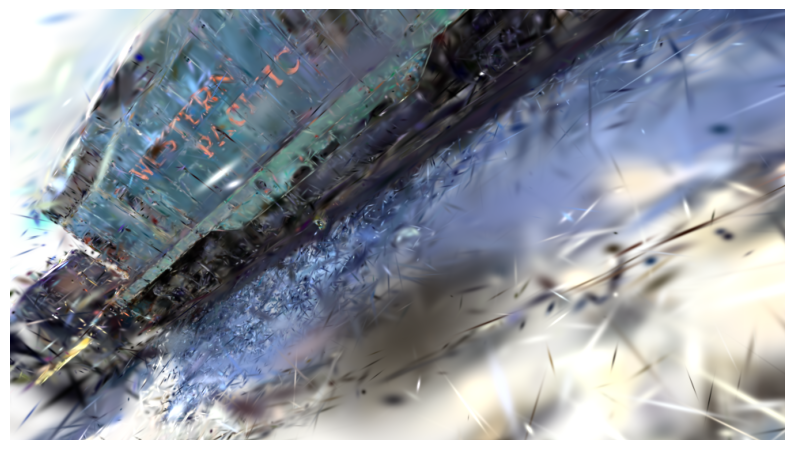

In [383]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(img.detach().cpu().numpy().transpose(1, 2, 0))
plt.axis("off")
plt.show()

/tmp/ipykernel_54382/3266151640.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quaternions = torch.tensor(quaternions, dtype=torch.float32)


(-0.5, 979.5, 544.5, -0.5)

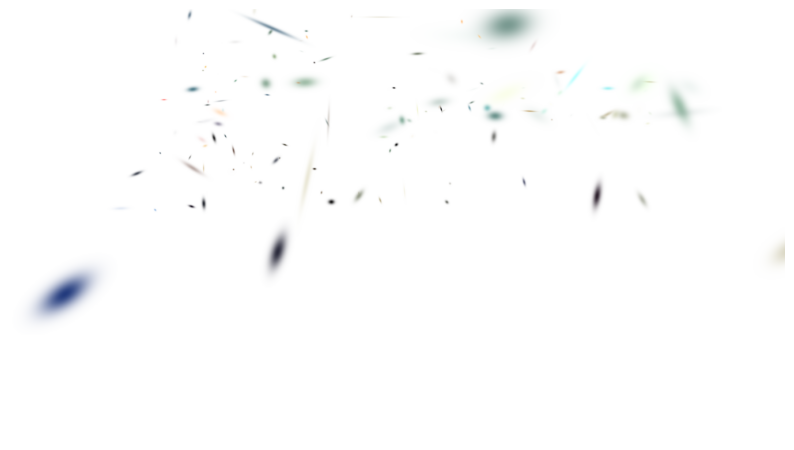

In [183]:
rotated_gaussians = copy_gaussians(gaussians, S, N)
rotated_gaussians._rotation = batch_apply_90_deg_rotation(new_gaussians._rotation, axis='x')
img_rotated = render(camera, rotated_gaussians, pipeline, background_color)["render"]

plt.figure(figsize=(10, 10))
plt.imshow(img_rotated.detach().cpu().numpy().transpose(1, 2, 0))
plt.axis("off")

In [21]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def define_transformations():
    # Quaternions for 180-degree rotations around each axis
    rotate_180_x = R.from_euler('x', 180, degrees=True).as_quat()
    rotate_180_y = R.from_euler('y', 180, degrees=True).as_quat()
    rotate_180_z = R.from_euler('z', 180, degrees=True).as_quat()

    # Quaternions for 90-degree rotations around each axis
    rotate_90_x = R.from_euler('x', 90, degrees=True).as_quat()
    rotate_90_y = R.from_euler('y', 90, degrees=True).as_quat()
    rotate_90_z = R.from_euler('z', 90, degrees=True).as_quat()

    # Define all possible transformations using quaternion products
    transformations = [
        R.from_quat([0, 0, 0, 1]),  # Identity
        R.from_quat(rotate_180_x),
        R.from_quat(rotate_180_y),
        R.from_quat(rotate_180_z),
        R.from_quat(rotate_180_x) * R.from_quat(rotate_90_y),
        R.from_quat(rotate_180_x) * R.from_quat(rotate_90_z),
        R.from_quat(rotate_180_y) * R.from_quat(rotate_90_x),
        R.from_quat(rotate_180_y) * R.from_quat(rotate_90_z),
        R.from_quat(rotate_180_z) * R.from_quat(rotate_90_x),
        R.from_quat(rotate_180_z) * R.from_quat(rotate_90_y),
        # Add more as necessary
    ]

    return [t.as_quat() for t in transformations]

def quaternion_to_axis_angle(quat):
    r = R.from_quat(quat)
    angle = 2 * np.arccos(np.clip(r.as_quat()[3], -1.0, 1.0))
    if angle > np.pi:
        angle = 2 * np.pi - angle  # Normalize the angle
    axis = r.as_rotvec() / np.linalg.norm(r.as_rotvec()) if np.linalg.norm(r.as_rotvec()) != 0 else [1, 0, 0]
    return axis, angle

def optimal_orientation(parent_quat, child_quat):
    transformations = define_transformations()
    min_angle = np.inf
    optimal_transform = None

    for t_quat in transformations:
        transformed_quat = R.from_quat(child_quat) * R.from_quat(t_quat)
        rotation_quat = R.from_quat(parent_quat) * R.from_quat(transformed_quat.as_quat()).inv()
        _, angle = quaternion_to_axis_angle(rotation_quat.as_quat())

        if abs(angle) < min_angle:
            min_angle = abs(angle)
            optimal_transform = t_quat

    return optimal_transform, min_angle

# Example usage
parent_quat = [0, 0, 0, 1]  # Example quaternion
child_quat = [0.707, 0, 0.707, 0]  # Example quaternion
optimal_transform, min_angle = optimal_orientation(parent_quat, child_quat)
optimal_transform, min_angle


(array([7.07106781e-01, 4.32978028e-17, 7.07106781e-01, 4.32978028e-17]), 0.0)

In [23]:
import torch
from scipy.spatial.transform import Rotation as R

def quat_to_rot_matrix(quat):
    return torch.tensor(R.from_quat(quat).as_matrix(), dtype=torch.float32)

def rot_matrix_to_quat(matrix):
    return R.from_matrix(matrix.numpy()).as_quat()

def aggregate_gaussians(means, scales, rotations, weights):
    N = len(means)
    
    # Convert quaternions to rotation matrices
    rotation_matrices = torch.stack([quat_to_rot_matrix(quat) for quat in rotations])
    
    # Compute weighted mean of the means
    weights = torch.tensor(weights, dtype=torch.float32)
    weights_sum = torch.sum(weights)
    weighted_mean = torch.sum(means * weights.unsqueeze(1), dim=0) / weights_sum
    
    # Initialize aggregated scales and rotation matrix components
    aggregated_scale = torch.zeros(3, dtype=torch.float32)
    aggregated_rot = torch.zeros((3, 3), dtype=torch.float32)
    
    for i in range(N):
        # Scale the rotation matrices by weights
        scaled_rot = rotation_matrices[i] * weights[i]
        
        # Aggregate the scales
        aggregated_scale += scales[i] * weights[i]
        
        # Aggregate the rotation matrices
        aggregated_rot += scaled_rot
    
    # Normalize the rotation matrix
    U, _, V = torch.svd(aggregated_rot)
    aggregated_rot = U @ V.T
    
    # Convert aggregated rotation matrix to quaternion
    aggregated_quat = rot_matrix_to_quat(aggregated_rot)
    
    return weighted_mean, aggregated_scale, aggregated_quat

# Example usage
means = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
], dtype=torch.float32)

scales = torch.tensor([
    [1.0, 0.5, 0.2],
    [0.8, 0.7, 0.3],
    [0.9, 0.6, 0.4]
], dtype=torch.float32)

rotations = [
    [0.0, 0.0, 0.0, 1.0],
    [0.0, 0.7071, 0.0, 0.7071],
    [0.0, 0.0, 0.7071, 0.7071]
]

weights = [0.2, 0.3, 0.5]

weighted_mean, aggregated_scale, aggregated_quat = aggregate_gaussians(means, scales, rotations, weights)

print("Weighted Mean:\n", weighted_mean)
print("Aggregated Scale:\n", aggregated_scale)
print("Aggregated Quaternion:\n", aggregated_quat)

Weighted Mean:
 tensor([4.9000, 5.9000, 6.9000])
Aggregated Scale:
 tensor([0.8900, 0.6100, 0.3300])
Aggregated Quaternion:
 [0.         0.21571963 0.43008959 0.87663447]


In [39]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_exhaustive_candidate_rotations():
    """Generate all 48 candidate rotations by permuting and flipping axes."""
    axes = np.array([
        [1, 0, 0], [0, 1, 0], [0, 0, 1],  # Identity axes
        [0, 1, 0], [1, 0, 0], [0, 0, 1],  # Swap X and Y
        [0, 0, 1], [0, 1, 0], [1, 0, 0],  # Swap Y and Z
        [1, 0, 0], [0, 0, 1], [0, 1, 0],  # Swap Z and X
        [0, -1, 0], [1, 0, 0], [0, 0, 1], # Swap and Negate X and Y
        [0, 0, 1], [0, -1, 0], [1, 0, 0], # Swap and Negate Y and Z
        [1, 0, 0], [0, 0, -1], [0, 1, 0]  # Swap and Negate Z and X
    ])
    candidates = []
    for i in range(0, len(axes), 3):
        for signs in np.ndindex(2, 2, 2):  # Generate all sign combinations
            signs = np.array(signs) * 2 - 1  # Convert 0, 1 to -1, 1
            matrix = np.diag(signs) @ axes[i:i+3]  # Apply signs and extract submatrix
            candidates.append(R.from_matrix(matrix))
    return candidates

def find_best_orientation(parent_cov, child_cov):
    candidates = generate_exhaustive_candidate_rotations()
    min_angle = np.inf
    best_rotation = None

    for candidate in candidates:
        rotated_cov = candidate.apply(child_cov, inverse=True)
        alignment_rotation = R.align_vectors(parent_cov, rotated_cov)[0]
        axis_angle = alignment_rotation.as_rotvec()
        angle = np.linalg.norm(axis_angle)

        if angle < min_angle:
            min_angle = angle
            best_rotation = candidate * alignment_rotation

            print(angle)

    return best_rotation

# Define more complex covariance matrices
# Parent Gaussian: Elongated and rotated about the z-axis by 45 degrees, then tilted by 15 degrees around the x-axis
parent_rotation = R.from_euler('zx', [45, 15], degrees=True)
parent_cov = parent_rotation.apply(np.diag([5, 1, 0.5]))

# Child Gaussian: More spherical but rotated about the y-axis by 30 degrees and then around the z-axis by 60 degrees
child_rotation = R.from_euler('yz', [30, 60], degrees=True)
child_cov = child_rotation.apply(np.diag([2, 2.5, 2]))

best_orientation = find_best_orientation(parent_cov, child_cov)
print("Best orientation rotation matrix:\n", best_orientation.as_matrix())


2.4719968808436525
0.7917076224630605
Best orientation rotation matrix:
 [[ 0.91855865  0.1767767  -0.35355339]
 [-0.36045794  0.74169394 -0.56565022]
 [ 0.16223463  0.64702403  0.74500995]]


In [21]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def rotation_matrix_to_quaternion(R):
    """
    Convert a 3x3 rotation matrix to a quaternion.
    
    Parameters:
    R (np.array): 3x3 rotation matrix
    
    Returns:
    np.array: Quaternion [w, x, y, z]
    """
    assert R.shape == (3, 3), "R must be a 3x3 matrix"
    
    # Calculate the trace of the matrix
    trace = np.trace(R)
    
    if trace > 0:
        s = 0.5 / np.sqrt(trace + 1.0)
        w = 0.25 / s
        x = (R[2, 1] - R[1, 2]) * s
        y = (R[0, 2] - R[2, 0]) * s
        z = (R[1, 0] - R[0, 1]) * s
    elif (R[0, 0] > R[1, 1]) and (R[0, 0] > R[2, 2]):
        s = 2.0 * np.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2])
        w = (R[2, 1] - R[1, 2]) / s
        x = 0.25 * s
        y = (R[0, 1] + R[1, 0]) / s
        z = (R[0, 2] + R[2, 0]) / s
    elif R[1, 1] > R[2, 2]:
        s = 2.0 * np.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2])
        w = (R[0, 2] - R[2, 0]) / s
        x = (R[0, 1] + R[1, 0]) / s
        y = 0.25 * s
        z = (R[1, 2] + R[2, 1]) / s
    else:
        s = 2.0 * np.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1])
        w = (R[1, 0] - R[0, 1]) / s
        x = (R[0, 2] + R[2, 0]) / s
        y = (R[1, 2] + R[2, 1]) / s
        z = 0.25 * s
    
    quaternion = np.array([w, x, y, z])
    return quaternion

def create_ellipsoid(mean, cov, n_points=100):
    """Generate points for a 3D ellipsoid based on the mean and covariance matrix."""
    eigvals, eigvecs = np.linalg.eigh(cov)
    radii = 3 * np.sqrt(eigvals)  # 3-sigma radii

    # Create a grid of points representing the ellipsoid
    u = np.linspace(0, 2 * np.pi, n_points)
    v = np.linspace(0, np.pi, n_points)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

    # Rotate the ellipsoid based on the eigenvectors
    ellipsoid_points = np.array([x.flatten(), y.flatten(), z.flatten()])
    ellipsoid_points = eigvecs @ ellipsoid_points
    x, y, z = ellipsoid_points[0, :].reshape((n_points, n_points)), ellipsoid_points[1, :].reshape((n_points, n_points)), ellipsoid_points[2, :].reshape((n_points, n_points))

    # Translate the ellipsoid to the mean
    x += mean[0]
    y += mean[1]
    z += mean[2]

    return x, y, z

# Define the mean and covariance
mean = np.array([0, 0, 0])
cov = np.diag([1, 1, 1])  # Identity matrix as covariance for simplicity

# Apply scaling along the x-axis
scaling_x = np.diag([2, 1, 1])
cov_scaled_x = scaling_x @ cov @ scaling_x.T

# Apply scaling along the y-axis and then rotate 90 degrees around z-axis
scaling_y = np.diag([1, 2, 1])
rotation_z = np.array([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]
])
cov_scaled_y_rotated_z = rotation_z @ scaling_y @ cov @ scaling_y.T @ rotation_z.T

print(cov_scaled_x)

print(cov_scaled_y_rotated_z)
print(rotation_matrix_to_quaternion(rotation_z))

# Generate ellipsoid points
x_orig, y_orig, z_orig = create_ellipsoid(mean, cov)
x_scaled_x, y_scaled_x, z_scaled_x = create_ellipsoid(mean, cov_scaled_x)
x_scaled_y_rotated_z, y_scaled_y_rotated_z, z_scaled_y_rotated_z = create_ellipsoid(mean, cov_scaled_y_rotated_z)

# Create a Plotly figure with subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=('Original Gaussian', 'Scaled along y-axis and Rotated')
)

# Add the original Gaussian ellipsoid
# fig.add_trace(
#     go.Surface(x=x_orig, y=y_orig, z=z_orig, opacity=0.5, colorscale='Blues'),
#     row=1, col=1
# )

# Add the Gaussian ellipsoid scaled along x-axis
fig.add_trace(
    go.Surface(x=x_scaled_x, y=y_scaled_x, z=z_scaled_x, opacity=0.5, colorscale='Reds'),
    row=1, col=1
)

# Add the Gaussian ellipsoid scaled along y-axis and rotated around z-axis
fig.add_trace(
    go.Surface(x=x_scaled_y_rotated_z, y=y_scaled_y_rotated_z, z=z_scaled_y_rotated_z, opacity=0.5, colorscale='Greens'),
    row=1, col=2
)

# Define a consistent camera perspective
camera = dict(
    eye=dict(x=1.25, y=1.25, z=1.25),
    center=dict(x=0, y=0, z=0),
    up=dict(x=0, y=0, z=1)
)

# Update layout for better visualization
fig.update_layout(
    title='3D Gaussian Ellipsoids at 3-Sigma Threshold',
    scene_camera=camera,
    scene2_camera=camera,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


[[4 0 0]
 [0 1 0]
 [0 0 1]]
[[4 0 0]
 [0 1 0]
 [0 0 1]]
[0.70710678 0.         0.         0.70710678]
